# TP Méthodes des différences temporelles -- SARSA et Q-Learning
Réalisé par:
- AYARI Mohamed Aziz
- YBEGGAZENE Zakaria

## Frozen Lake

L'environnement Frozen Lake est un monde grille incertain dans lequel on part depuis un état initial (la case la plus en haut à gauche) pour aller à un état final (la case la plus basse à droite). L'environnement est incertain car vous marchez sur un lac gelé et l'épaisseur de glace varie. Vous pouvez donc tomber dans l'eau dans certaines cases. De plus, la glace est plus glissante à certains endroits, et donc faire un pas peut vous mener plus loin que prévu... et si le vent s'en mèle...

Au lieu d'essayer d'estimer le modèle de transition, on va utiliser SARSA et Q-learning pour résoudre ce problème.

Utilisez l'environnement Frozen Lake pour implémenter SARSA et Q-learning. Utilisez d'abord l'environnement avec une grille 4x4 pour tester vos algorithmes, puis vous devriez pouvoir les utiliser pour la grille 16x16.



## FrozenLake - familiarisation avec l'environnement

Evaluez une politique aléatoire. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gym
#env = gym.make("FrozenLake8x8-v0",  is_slippery=True)
env = gym.make("FrozenLake-v1")
numStates = env.observation_space.n
numActions = env.action_space.n
print("Environnement avec ", numStates, " états et ", numActions, " actions")
#
# env.reset() fait commencer un nouvel épisode
# la méthode retourne l'état initial
#
state = env.reset()
nbIt=0
rew=[]
done=False
while not done:
    #
    # env.step(action) exécute une action dans l'état courant
    # la méthode retourne:
    #    • l'état suivant
    #    • la récompense immédiate
    #    • un booléen qui indique si l'épisode est terminé
    #    • le quatrième argument ne nous est pas utile (sert pour le debuggage dans certains cas)
    #
    nextState, reward, done, info = env.step(np.random.randint(4))
    print("etat numero:",nextState)
    #
    # env.render donne une réprésentation de l'état.
    #
    env.render()
    nbIt+=1
    rew = rew+[reward]
print("Episode terminé après {} itérations".format(nbIt))
print("Récompenses obtenues:",rew)
env.close()

Environnement avec  16  états et  4  actions
etat numero: 0
  (Up)
SFFF
FHFH
FFFH
HFFG
etat numero: 1
  (Down)
SFFF
FHFH
FFFH
HFFG
etat numero: 5
  (Right)
SFFF
FHFH
FFFH
HFFG
Episode terminé après 3 itérations
Récompenses obtenues: [0.0, 0.0, 0.0]


## $\epsilon$-greedy

Implémentez une fonction qui retourne une action avec la stratégie $\epsilon$-greedy:
* exploite avec un probabilité $1-\epsilon$: ici on choisit l'action avec la meilleure valeur de $q[s]$
* explore avec une probabilité $\epsilon$: on choisit une action de manière uniforme sur toute les actions.

Vous pouvez choisir différente signature pour la fonction:
soit en lui passant:
 * le paramètre $\epsilon$
 * la table `Q`
 * l'état `s` dans lequel l'action sera exécutée
 * donc l'appel aura la forme `action = epsGreedy(eps, Q, s)`

 Autre solution, vous pouvez donner seulement la valeur de $\epsilon$ et vecteur Q(s) (qui a pour dimension le nombre d'actions). L'appel aura donc la forme `action = epsGreedy(eps, q)`

*Attention* On peut imaginer le cas particulier où on trouve plusieurs occurrence de la valeur max dans le vecteur `Q(s)`. Dans ce cas, il ne faudrait pas *toujours* choisir la même action, mais plutôt choisir une des actions ex-aequo au hasard. 
Ce cas n'est peut-être pas si exotique que cela, en particulier en début d'apprentissage, quand toutes les valeurs sont nulles. Pour explorer, il est alors souhaitable de répéter le même choix!


Pour ceux peu familier avec python, regardez le petit exemple de code ci-dessous pour illustrer quelques fonctions de la bibliothèque `numpy`
- La fonction `np.random.rand()` tire une valeur de manière uniforme entre 0 et 1. 
- La fonction np.random.choice permet de choisir de manière uniforme une valeur parmi un ensemble.
- La fonction `np.argwhere(l)` permet de donner les indices où l'entrée du vecteur l est non nul. On peut donc coupler un appel de `np.argwhere` avec un test.



In [2]:
val = np.random.rand()
print(val)
val=np.zeros(10)
# on tire au sort 10 fois une valeur dans l'ensemble {1, 3, 5}
for i in range(10):
    val[i]=np.random.choice([1,3,5])
_, count = np.unique(val,return_counts=True)
print("résultat des 10 tirages:", val)
print("la proportion de chaque valeur sur ces 10 tirages est ", count/10)
indices3 = np.argwhere(val==3)
print("Les indices de la liste val où la valeur est 3 sont:", indices3)

def epsGreedy(eps, Q, s):
    if np.random.rand() < eps:
        return np.random.choice(len(Q[s]))
    else:
        return np.random.choice(np.where(Q[s] == np.max(Q[s]))[0])

0.1440838789440242
résultat des 10 tirages: [1. 1. 3. 1. 1. 5. 1. 5. 3. 3.]
la proportion de chaque valeur sur ces 10 tirages est  [0.5 0.3 0.2]
Les indices de la liste val où la valeur est 3 sont: [[2]
 [8]
 [9]]


## Tester une politique

Lors de l'apprentissage, il est nécessaire d'explorer, ainsi lorsqu'on analyse les performances durant l'apprentissage, il faut avoir à l'esprit qu'une partie des choix est faite au hasard. Après avoir appris, on peut faire un test en étant glouton: à chaque état, on choisit toujours l'action qui donne la plus haute valeur de `Q`.
Implémentez une méthode qui prend en paramètre un nombre d'épisodes fixé, une table `Q`, et qui exécute la politique gloutone. La méthode retourne la valeur moyenne de la somme des récompenses sur l'épisode.

In [3]:
def greedy_policy(numEpisodes, Q):
    sums_rew = np.zeros(numEpisodes)
    for i in range(numEpisodes):
        state = env.reset()
        sum_rew = 0
        done=False
        while not done:
            # on choisi toujours la meilleure action (eps == 0)
            state, reward, done, _ = env.step(epsGreedy(0, Q, state))
            sum_rew += reward
        sums_rew[i] = sum_rew
    return np.mean(sums_rew)

### SARSA

Implémentez un fonction SARSA qui prend en paramètre
 * un nombre d'épisodes utilisés pour l'apprentissage
 * $\gamma$ le taux d'escompte
 * $\alpha$ le taux d'apprentissage (que l'on retrouve lors de la mise à jour des valeurs de Q)
 * $\epsilon$ le paramètre pour la méthode $\epsilon$-greedy.

Votre fonction doit au moins retourner la table $Q: S \times A$. Vous trouverez ci-dessous une fonction $plotQ$ qui génère une représentation de la table $Q$: pour chaque case sera dessiné la meilleure action selon $Q$ et la couleur représentera la valeur de cette action.
 
Pour visualiser les progrès faits pendant l'apprentissage, votre fonction SARSA peut également retourner une séquence de valeurs. Par exemple,
 * la séquence de récompenses (totale ou moyenne) obtenue sur chaque épisode de l'apprentissage
 * la valeur de la meilleure action pour l'état de départ à chaque fin d'épisode.
 * au lieu d'utiliser les valeurs obtenues lors de l'apprentissage, vous pouvez aussi effectuer périodiquement une évaluation de la politique courante (sans exploration). Pour ce faire, vous pouvez calculer la performance sur un petit nombre d'épisodes et retourner la moyenne. Cette méthode a l'avantage d'évaluer la politique sans exploration (donc une meilleure évaluation de la politique), mais peut coûter cher en temps de calcul suivant la fréquence d'exécution et le nombre d'épisodes utilisés pour l'évaluation.

En générant le graphique, vous devriez visualiser si l'algorithme est arrivé à améliorer les performances. Vous pouvez soit tracer directement la valeur de chaque épisode. Pour avoir une courbe un peu plus lisse, vous pouvez aussi calculer une moyenne sur une fenêtre de $k$ épisodes (la fonction $runningAvg$ effectue ce travail).

Notez qu'on considère Frozen lake comme résolu quand
 * il atteint le but dans 78% des épisodes pour la grille 4x4.
 * a priori, on peut atteindre 100% pour la grille 8x8

Quelques idées pour aider au debeug:
 * vous pouvez aussi regarder si la plupart des paires état-actions ont été exécutée. 
 * Vous pouvez choisir comme paramètres (le code que j'ai écrit a fonctionné avec ces paramètres, évidemment, vous pouvez essayer avec d'autres par la suite).
   * $\epsilon=0.2$
   * $\alpha=0.02$
   * Frozen lake est une tâche épisodique, donc ici, on peut s'intéresser simplement à la somme des récompenses accumulées lors d'un épisode. Donc on peut choisir $\gamma=1$ (pas d'escompte).

In [4]:
def SARSA(numEpisodes, gamma, alpha, eps, eval_frequency=1000, num_eval_episodes=1000):
    numStates = env.observation_space.n
    numActions = env.action_space.n
    Q = np.zeros((numStates, numActions))
    # vecteur pour la somme des récompenses lors de l'apprentissage
    train_rewards = np.zeros(numEpisodes)
    # liste pour la somme des récompenses obtenues lors de l'évaluation
    eval_rewards = []
    for i in range(numEpisodes):
        state = env.reset()
        action = epsGreedy(eps, Q, state)
        sum_rew = 0
        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            if done:
                Q[state][action] += alpha * (reward - Q[state][action])
            else:
                next_action = epsGreedy(eps, Q, next_state)
                Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state = next_state
            action = next_action
            sum_rew += reward
        # on effectue une evaluation gloutonne de la politique après chaque `eval_frequency` episodes
        if (i % eval_frequency) == 0:
            eval_rew = greedy_policy(num_eval_episodes, Q)
            eval_rewards.append(eval_rew)
        train_rewards[i] = sum_rew
    return Q, train_rewards, eval_rewards

In [5]:
def runningAvg(data, windowSize):
  res = np.zeros(len(data)-windowSize)
  sum=0
  for i in range(windowSize):
    sum += data[i]
  for i in range(len(data)-windowSize):
    res[i]= sum/windowSize
    sum -= data[i]
    sum += data[i+windowSize]
  return res


# visualisation de la table Q pour FrozenLake 4x4 et 8x8
# passez la taille (4 ou 8) en paramètres
def plotQ(q_table, map_size):
  if (map_size==4):
    MAP = [
        "SFFF",
        "FHFH",
        "FFFF",
        "HFFG"
    ]
  else:
    MAP=[
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]
  best_value = np.max(q_table, axis = 1).reshape((map_size,map_size))
  best_policy = np.argmax(q_table, axis = 1).reshape((map_size,map_size))
    
  fig, ax = plt.subplots()
  im = ax.imshow(best_value)

  for i in range(best_value.shape[0]):
      for j in range(best_value.shape[1]):
          if MAP[i][j] in 'GH':
              arrow = MAP[i][j]
          elif best_policy[i, j] == 0:
              arrow = '<'
          elif best_policy[i, j] == 1:
              arrow = 'v'
          elif best_policy[i, j] == 2:
              arrow = '>'
          elif best_policy[i, j] == 3:
              arrow = '^'
          if MAP[i][j] in 'S':
              arrow = 'S ' + arrow
          text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
            
  cbar = ax.figure.colorbar(im, ax = ax)
    
  fig.tight_layout()
  plt.show() 

### Grille 4x4

In [6]:
env = gym.make("FrozenLake-v1")
Q4_s, sarsa_rewards4, sarsa_eval_rewards4 = SARSA(50000, gamma=1, alpha=0.02, eps=0.2)
env.close()

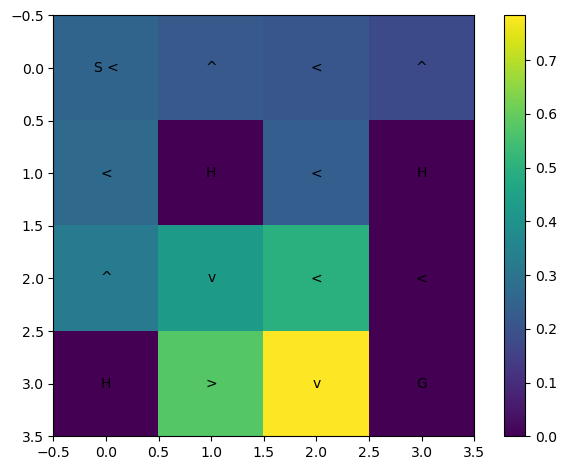

In [7]:
plotQ(Q4_s, 4)

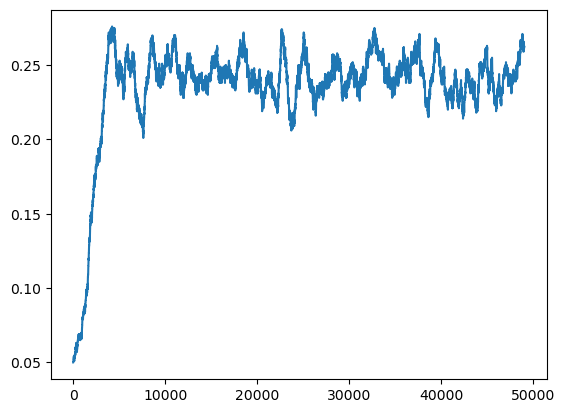

In [8]:
# rewards apprentissage
res4_s = runningAvg(sarsa_rewards4, 1000)
plt.plot(res4_s)
plt.show()

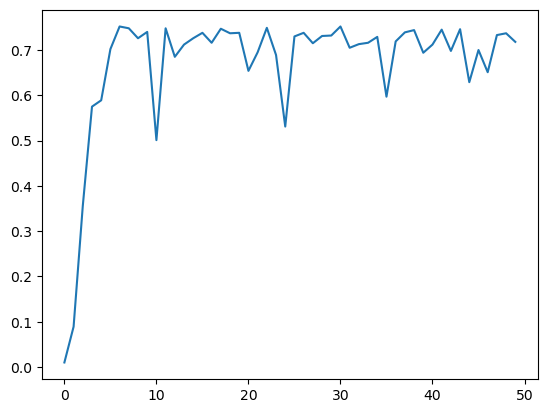

In [9]:
# rewards validation
plt.plot(sarsa_eval_rewards4)
plt.show()

In [42]:
# lancer un episode
env = gym.make("FrozenLake-v1")
state = env.reset()
done=False
while not done:
    # on choisi toujours la meilleure action (eps == 0)
    state, reward, done, _ = env.step(epsGreedy(0, Q4_s, state))
    env.render()
print("récompense :", reward)
env.close()

  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH

### Grille 8x8

In [10]:
env = gym.make("FrozenLake-v1", map_name="8x8")
Q8_s, sarsa_rewards8, sarsa_eval_rewards8 = SARSA(50000, gamma=1, alpha=0.02, eps=0.2)
env.close()

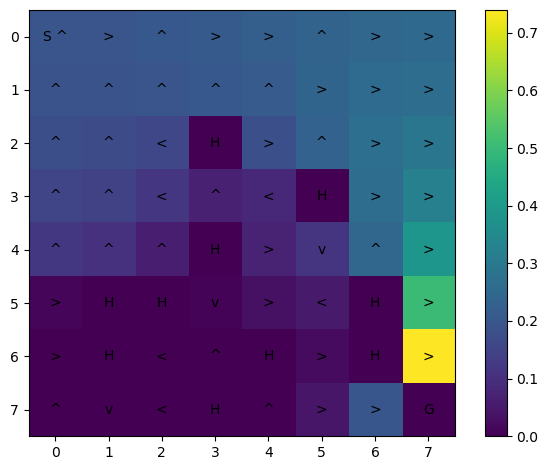

In [11]:
plotQ(Q8_s, 8)

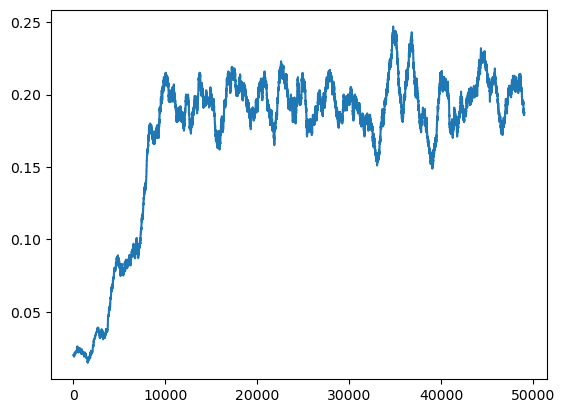

In [12]:
# rewards apprentissage
res8_s = runningAvg(sarsa_rewards8, 1000)
plt.plot(res8_s)
plt.show()

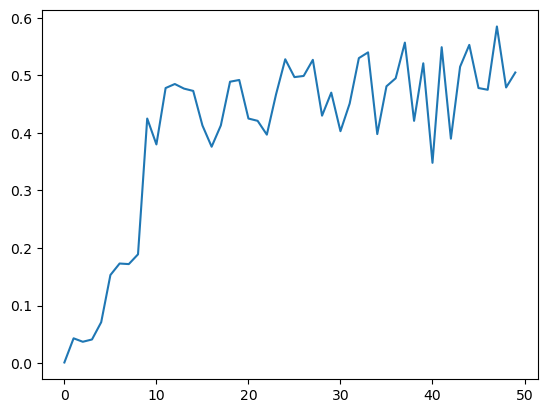

In [13]:
# rewards validation
plt.plot(sarsa_eval_rewards8)
plt.show()

In [43]:
# lancer un episode
env = gym.make("FrozenLake-v1", map_name="8x8")
state = env.reset()
done=False
while not done:
    # on choisi toujours la meilleure action (eps == 0)
    state, reward, done, _ = env.step(epsGreedy(0, Q8_s, state))
    env.render()
print("récompense :", reward)
env.close()

  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFF

## Q-learning
Implémentez l'algorithme Q-learning (en partant de SARSA, il ne devrait y avoir que quelques lignes de codes à modidier!)



In [6]:
def QLearning(numEpisodes, gamma, alpha, eps, eval_frequency=1000, num_eval_episodes=1000):
    numStates = env.observation_space.n
    numActions = env.action_space.n
    Q = np.zeros((numStates, numActions))
    # vecteur pour la somme des récompenses lors de l'apprentissage
    train_rewards = np.zeros(numEpisodes)
    # liste pour la somme des récompenses obtenues lors de l'évaluation
    eval_rewards = []
    for i in range(numEpisodes):
        state = env.reset()
        action = epsGreedy(eps, Q, state)
        sum_rew = 0
        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            if done:
                Q[state][action] += alpha * (reward - Q[state][action])
            else:
                max_action = np.random.choice(np.where(Q[next_state] == np.max(Q[next_state]))[0])
                Q[state][action] += alpha * (reward + gamma * Q[next_state][max_action] - Q[state][action])
                next_action = epsGreedy(eps, Q, next_state)
            state = next_state
            action = next_action
            sum_rew += reward
        # on effectue une evaluation gloutonne de la politique après chaque `eval_frequency` episodes
        if (i % eval_frequency) == 0:
            eval_rew = greedy_policy(num_eval_episodes, Q)
            eval_rewards.append(eval_rew)
        train_rewards[i] = sum_rew
    return Q, train_rewards, eval_rewards

### Grille 4x4

In [15]:
env = gym.make("FrozenLake-v1")
Q4_q, q_rewards4, q_eval_rewards4 = QLearning(50000, gamma=1, alpha=0.02, eps=0.2)
env.close()

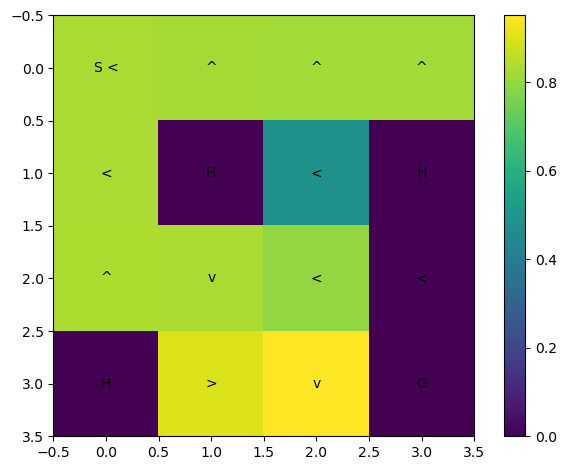

In [16]:
plotQ(Q4_q, 4)

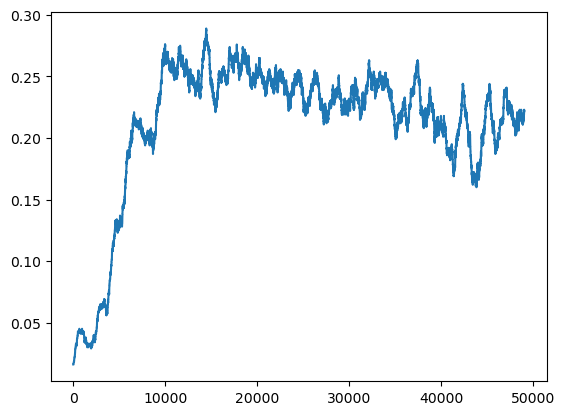

In [17]:
# rewards apprentissage
res4_q = runningAvg(q_rewards4, 1000)
plt.plot(res4_q)
plt.show()

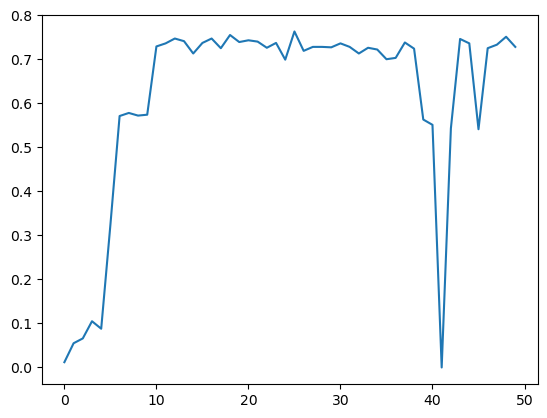

In [18]:
# rewards validation
plt.plot(q_eval_rewards4)
plt.show()

In [44]:
# lancer un episode
env = gym.make("FrozenLake-v1")
state = env.reset()
done=False
while not done:
    # on choisi toujours la meilleure action (eps == 0)
    state, reward, done, _ = env.step(epsGreedy(0, Q4_q, state))
    env.render()
print("récompense :", reward)
env.close()

  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
récompense : 1.0


### Grille 8x8

In [19]:
env = gym.make("FrozenLake-v1", map_name="8x8")
Q8_q, q_rewards8, q_eval_rewards8 = QLearning(50000, gamma=1, alpha=0.02, eps=0.2)
env.close()

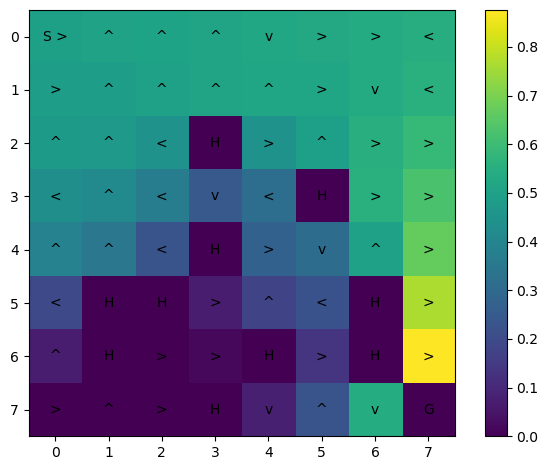

In [20]:
plotQ(Q8_q, 8)

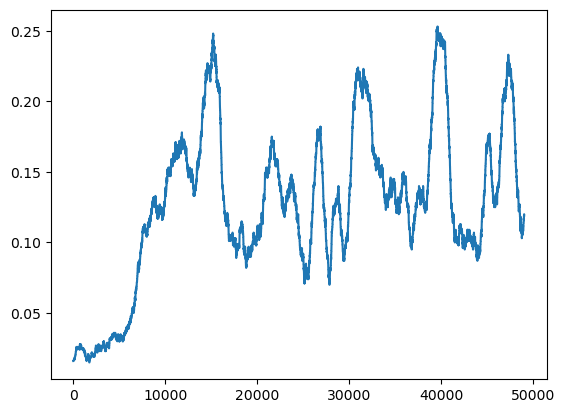

In [21]:
# rewards apprentissage
res8_q = runningAvg(q_rewards8, 1000)
plt.plot(res8_q)
plt.show()

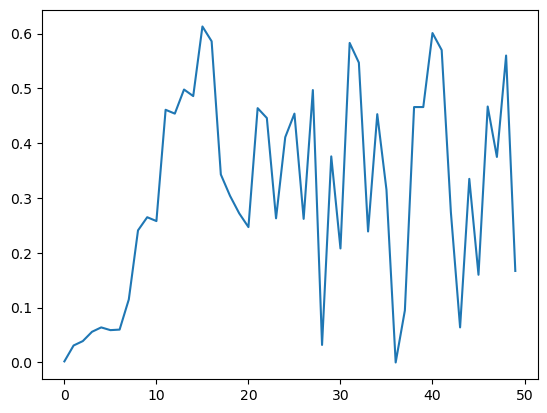

In [22]:
# rewards validation
plt.plot(q_eval_rewards8)
plt.show()

In [50]:
# lancer un episode
env = gym.make("FrozenLake-v1", map_name="8x8")
state = env.reset()
done=False
while not done:
    # on choisi toujours la meilleure action (eps == 0)
    state, reward, done, _ = env.step(epsGreedy(0, Q8_q, state))
    env.render()
print("récompense :", reward)
env.close()

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
F

## Comparaison

Comparer les politiques trouvées à l'aide de SARSA, Q-learning, et vous devriez aussi pouvoir utiliser le code de l'algorithme on policy Monte Carlo du TD précédent.

Avant convergence à l'optimal, on observe souvent que SARSA a choisi une politique moins risquée avant de tomber sur l'optimal pour le FrozenLake8x8.

***Utilisation de on policy Monte Carlo***

In [12]:
def draw(pi):
    """
    prend en paramètre une distribution de probabilités sur
    les actions et qui tire une action au hasard en utilisant cette distribution
    """
    action=np.random.choice(len(pi), p=pi)
    return action

def episode_func(pi):
    """
    générer un épisode 
    """
    state=env.reset()
    episode=[]
    while True:
        action = draw(pi[state])
        next_state, reward, done, info = env.step(action)
        episode.append((state,action,reward))
        state = next_state
        if done==True:
            break
    return episode

def onPolicyMC(num_episodes, gamma, epsilon):
    #Initialisation
    q = np.zeros((numStates,numActions))
    count = np.zeros((numStates,numActions))
    Acc = np.zeros((numStates,numActions))
    pi = np.full((numStates,numActions), (1/numActions))
    # génération des épisodes
    for ep in range(num_episodes):
        # génération d'un épisode
        visited_s_a = []
        episode = episode_func(pi)
        states, actions, rewards = zip(*episode)
        L = len(episode)
        G_t = 0
        List_Gt = []
        # calcule G_t
        for t in reversed(range(L)):     
            state_t = states[t]
            reward_t = rewards[t]
            action_t = actions[t]
            G_t = reward_t + gamma * G_t
            List_Gt.append(G_t)
        # Mise à jour
        List_Gt.reverse()
        for t in range(L):
            state_t = states[t]
            reward_t = rewards[t]
            action_t = actions[t]
            if (state_t, action_t) not in visited_s_a :
                Acc[state_t, action_t] += List_Gt[t]
                count[state_t, action_t] += 1
                q[state_t, action_t] = (Acc[state_t, action_t] / count[state_t, action_t])
                visited_s_a.append((state_t, action_t))
            for s in states:
                action_optimal = epsGreedy(0, q , s)
                #mise à jour de la politique
                for a in range(numActions):
                    if a == action_optimal:
                        pi[s, a] = 1 - epsilon + (epsilon/numActions)
                    else:
                        pi[s, a] = (epsilon/numActions)
    return q, pi

In [13]:
env = gym.make("FrozenLake-v1")
Q4_mc, pi = onPolicyMC(10000, 1, 0.2)
env.close()

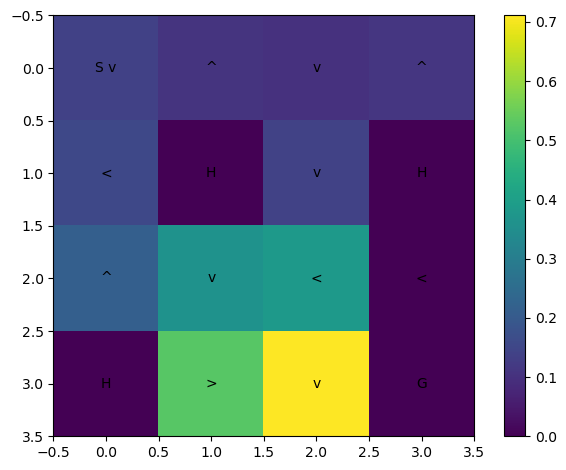

In [14]:
plotQ(Q4_mc, 4)

**Dans notre cas, on n'arrive pas toujours à atteindre l'objectif (même pour FrozenLake8x8, on a pas 100%). Cependant, avec des essais qu'on a fait manuellement, on s'est rendu compte que pour le FrozenLake8x8, il y a certains épidoses qui terminent dans un état non terminal et on n'a rencontré aucun épisode où on tombe dans un trou (ce qui veut dire qu'on a appris une bonne politique même si peut-être elle n'est pas optimale).**

**On remarque dans l'apprentissage que Q-Learning améliore sa politique plus rapidement que SARSA et MC on-policy mais il arrive parfois qu'il prenne de mauvaises actions et doit réapprendre une nouvelle fois.**

## Cart-pole en tabulaire

On vous propose pour finir d'utiliser votre code et de tester l'apprentissage sur le problème du cart-pole. A priori, c'est un problème où les états sont des variables continues. On vous propose ici de discrétiser les variables et d'essayer d'utiliser une des méthodes pour voir vos résultats. 

La récompense que vous obtenez est le nombre de pas de temps où le baton est resté en équilibre. Si vous utilisez colab pour coder, vous ne pourrez malheureusement pas visualiser un épisode avec la méthode render :-(

Cet environnement Cart-Pole consiste à déplacer un chariot pour faire tenir en équilibre une poutre. Plus précisément:
* Il y a deux actions : gauche et droite (représentées par 0 et 1).
* L'observation reçue (c'est à dire l'état) est un tableau numpy comprenant 4 variables: la position du chariot, la vélocité, l'angle à la verticale et la position du haut de la poutre.
* L'épisode se termine lorsque l'angle de la poutre à la verticale dépasse 12 degrés.
* Les récompenses reçues sont égales à 1 sauf si l'angle dépasse 12 degrés.

On vous donne ci-dessous les fonctions pour réaliser la discrétisation et pour encoder l'état en un entier.


In [23]:
env = gym.make("CartPole-v1")
print("environnement avec ", env.action_space.n, " actions")
print("l'espace des états est lui codé avec une class", env.observation_space,
      " qui représente un espace continu")
print("les bornes inférieures des intervalles sont: ", env.observation_space.low)
print("les bornes supérieures des intervalles sont: ",env.observation_space.high)
env.reset()
nbIt=0
done=False
while not done:
  observation, reward, done, info = env.step(np.random.randint(2))
  nbIt+=1
print("Episode terminé après {} itérations".format(nbIt))
env.close()

environnement avec  2  actions
l'espace des états est lui codé avec une class Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)  qui représente un espace continu
les bornes inférieures des intervalles sont:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
les bornes supérieures des intervalles sont:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Episode terminé après 21 itérations


In [24]:
def discretise(x,mini,maxi): 
  # discretise x
  # renvoie un entier entre 0 et nval-1
  if x<mini: x=mini
  if x>maxi: x=maxi
  return int(np.floor((x-mini)*nval/(maxi-mini+0.0001)))

def encode(observation):
  pos = discretise(observation[0],mini=-1,maxi=1)
  vel = discretise(observation[1],mini=-1,maxi=1)
  angle = discretise(observation[2],mini=-1,maxi=1)
  pos2 = discretise(observation[3],mini=-1,maxi=1)
  return pos + vel*nval + angle*nval*nval + pos2*nval*nval*nval
  

In [25]:
nval =5 # nombre de valeurs discrètes qu’une variable peut prendre
N= nval ** 4 # Puisqu’il y a 4 variables, la taille de l’espace est nval^4
print("Le nombre d'états sera ici de ", N)

Le nombre d'états sera ici de  625


Modifiez votre implémentation de Q-learning et/ou de SARSA pour tester si vous pouvez apprendre à maintenier le baton en équilibre. Une modification sera d'utilisé les fonctions ci-dessus pour encoder/decoder un état. Une autre sera surement d'ajouter le nombre d'états en paramètre car ce nombre est maintenant indépendant de l'environnement! 
Avec comme paramètre $\epsilon=0.1$, $\alpha=0.2$ et $\gamma=0.9$, j'arrive a atteindre un score autour de 90 pas de temps.

In [26]:
def greedy_policy_cartpole(numEpisodes, Q):
    sums_rew = np.zeros(numEpisodes)
    for i in range(numEpisodes):
        state = encode(env.reset())
        sum_rew = 0
        done=False
        while not done:
            # on choisi toujours la meilleure action (eps == 0)
            obs, reward, done, _ = env.step(epsGreedy(0, Q, state))
            state = encode(obs)
            sum_rew += reward
        sums_rew[i] = sum_rew
    return np.mean(sums_rew)

In [27]:
def QLearning_cartpole(numEpisodes, nval, gamma, alpha, eps, eval_frequency=100, num_eval_episodes=100):
    numStates = nval ** env.observation_space.shape[0]
    numActions = env.action_space.n
    Q = np.zeros((numStates, numActions))
    # vecteur pour la somme des récompenses lors de l'apprentissage
    train_rewards = np.zeros(numEpisodes)
    # liste pour la somme des récompenses obtenues lors de l'évaluation
    eval_rewards = []
    for i in range(numEpisodes):
        state = encode(env.reset())
        action = epsGreedy(eps, Q, state)
        sum_rew = 0
        done = False
        while not done:
            next_obs, reward, done, _ = env.step(action)
            next_state = encode(next_obs)
            if done:
                Q[state][action] += alpha * (reward - Q[state][action])
            else:
                max_action = np.random.choice(np.where(Q[next_state] == np.max(Q[next_state]))[0])
                Q[state][action] += alpha * (reward + gamma * Q[next_state][max_action] - Q[state][action])
                next_action = epsGreedy(eps, Q, next_state)
            state = next_state
            action = next_action
            sum_rew += reward
        # on effectue une evaluation gloutonne de la politique après chaque `eval_frequency` episodes
        if (i % eval_frequency) == 0:
            eval_rew = greedy_policy_cartpole(num_eval_episodes, Q)
            eval_rewards.append(eval_rew)
        train_rewards[i] = sum_rew
    return Q, train_rewards, eval_rewards

In [28]:
Q, rewards, eval_rewards = QLearning_cartpole(2000, 5, gamma=0.9, alpha=0.2, eps=0.1)

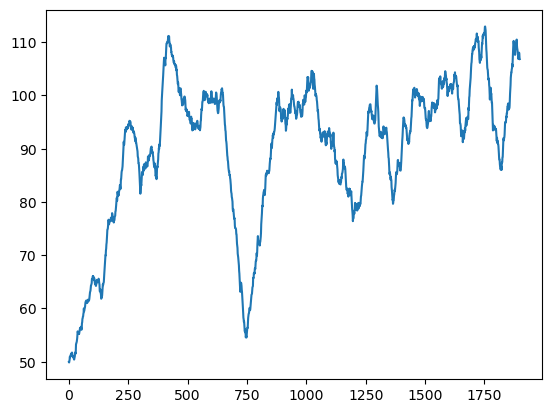

In [29]:
# rewards apprentissage
res = runningAvg(rewards, 100)
plt.plot(res)
plt.show()

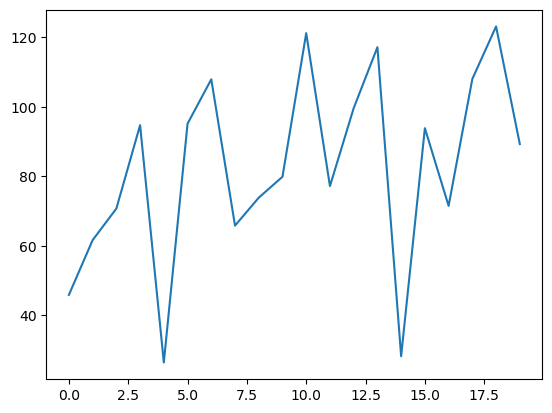

In [30]:
# rewards validation
plt.plot(eval_rewards)
plt.show()

On fait une évaluation gloutonne de la politique apprise : elle fait souvent **plus de 100 pas de temps**.

Avec ~ 10000 épisodes à l'entraînement, il est possible d'apprendre une politique qui réalise *plus de 200 pas de temps* à l'évaluation (sans exploration).

In [32]:
greedy_policy_cartpole(1000, Q)

84.382